In [3]:

import numpy as np
import matplotlib.pyplot as plt
import time

def autocorrelation_fft(x, max_lag=None):

    """
    Efficiently compute autocorrelation function using FFT.
    
    Parameters:
    -----------
    x : array
        1D array of samples
    max_lag : int, optional
        Maximum lag to compute (default: len(x)//3)
        
    Returns:
    --------
    acf : array
        Autocorrelation function values
    """
    n = len(x)
    if max_lag is None:
        max_lag = min(n // 3, 1000)  # Cap at 1000 to prevent slow computation
    
    # Remove mean and normalize
    x_norm = x - np.mean(x)
    var = np.var(x_norm)
    x_norm = x_norm / np.sqrt(var)
    
    # Compute autocorrelation using FFT
    # Pad the signal with zeros to avoid circular correlation
    fft = np.fft.fft(x_norm, n=2*n)
    acf = np.fft.ifft(fft * np.conjugate(fft))[:n]
    acf = acf.real / n  # Normalize
    
    return acf[:max_lag]

def integrated_autocorr_time(x, M=5, c=10):
    """
    Estimate the integrated autocorrelation time using a self-consistent window.
    Based on the algorithm described by Goodman and Weare.
    
    Parameters:
    -----------
    x : array
        1D array of samples
    M : int, default=5
        Window size multiplier (typically 5-10)
    c : int, default=10
        Maximum lag cutoff for window determination
        
    Returns:
    --------
    tau : float
        Integrated autocorrelation time
    acf : array
        Autocorrelation function values
    ess : float
        Effective sample size
    """
    n = len(x)
    orig_x = x.copy()
    
    # Initial pairwise reduction if needed
    k = 0
    max_iterations = 10  # Prevent infinite loop
    
    while k < max_iterations:
        # Calculate autocorrelation function
        acf = autocorrelation_fft(x)
        
        # Calculate integrated autocorrelation time with self-consistent window
        tau = 1.0  # Initialize with the first term
        
        # Find the window size where window <= M * tau
        for window in range(1, len(acf)):
            # Update tau with this window
            tau_window = 1.0 + 2.0 * sum(acf[1:window+1])
            
            # Check window consistency: window <= M*tau
            if window <= M * tau_window:
                tau = tau_window
            else:
                break
        
        # If we have a robust estimate, we're done
        if n >= c * tau:
            # Scale tau back to the original time scale: tau_0 = 2^k * tau_k
            tau = tau * (2**k)
            break
            
        # If we don't have a robust estimate, perform pairwise reduction
        k += 1
        n_half = len(x) // 2
        x_new = np.zeros(n_half)
        for i in range(n_half):
            if 2*i + 1 < len(x):
                x_new[i] = 0.5 * (x[2*i] + x[2*i+1])
            else:
                x_new[i] = x[2*i]
        x = x_new
        n = len(x)
    
    # If we exited without a robust estimate, compute one final estimate
    if k >= max_iterations or n < c * tau:
        acf = autocorrelation_fft(orig_x)
        tau_reduced = 1.0 + 2.0 * sum(acf[1:min(len(acf), int(M)+1)])
        # Scale tau back to the original time scale
        tau = tau_reduced * (2**k)
    
    # Calculate effective sample size using original series length
    ess = len(orig_x) / tau
    
    return tau, acf, ess


In [4]:
def langevin_walk_move(gradient_func, potential_func, initial, n_samples, n_chains_per_group=5, 
                      h=0.01, n_thin=1):
    """
    Vectorized Langevin Walk Move sampler - covariance preconditioned Langevin.
    
    The algorithm uses ensemble-based preconditioning where the covariance matrix
    is estimated from the other group of chains.
    
    Parameters:
    -----------
    gradient_func : callable
        Function that computes the gradient of the potential V(x)
    potential_func : callable
        Function that computes the potential V(x)
    initial : np.ndarray
        Initial state
    n_samples : int
        Number of samples to collect
    n_chains_per_group : int
        Number of chains per group (default: 5)
    h : float
        Step size (default: 0.01)
    n_thin : int
        Thinning factor - store every n_thin sample (default: 1, no thinning)
    
    Returns:
    --------
    samples : np.ndarray
        Collected samples from all chains
    acceptance_rates : np.ndarray
        Acceptance rates for all chains
    """
    
    # Initialize
    orig_dim = initial.shape
    flat_dim = np.prod(orig_dim)
    total_chains = 2 * n_chains_per_group
    
    # Create initial states with small random perturbations
    states = np.tile(initial.flatten(), (total_chains, 1)) + 0.1 * np.random.randn(total_chains, flat_dim)
    
    # Split into two groups
    group1 = slice(0, n_chains_per_group)
    group2 = slice(n_chains_per_group, total_chains)
    
    # Calculate total iterations needed based on thinning factor
    total_iterations = n_samples * n_thin
    
    # Storage for samples and acceptance tracking
    samples = np.zeros((total_chains, n_samples, flat_dim))
    accepts = np.zeros(total_chains)
    
    # Sample index to track where to store thinned samples
    sample_idx = 0
    
    # Main sampling loop
    for i in range(total_iterations):
        # Store current state from all chains (only every n_thin iterations)
        if i % n_thin == 0 and sample_idx < n_samples:
            samples[:, sample_idx] = states
            sample_idx += 1
        
        # Update group 1 using covariance from group 2
        if n_chains_per_group > 1:
            # Compute empirical covariance from group 2
            group2_centered = states[group2] - np.mean(states[group2], axis=0)
            empirical_cov2 = np.cov(group2_centered, rowvar=False) + 1e-6 * np.eye(flat_dim)
        else:
            # Fallback to identity if only one chain per group
            empirical_cov2 = np.eye(flat_dim)
            
        # Preconditioned Langevin update for group 1
        current_q1 = states[group1].copy()
        current_q1_reshaped = current_q1.reshape(n_chains_per_group, *orig_dim)
        current_U1 = potential_func(current_q1_reshaped)
        
        # Compute gradient
        grad1 = gradient_func(current_q1_reshaped).reshape(n_chains_per_group, -1)
        grad1 = np.nan_to_num(grad1, nan=0.0)
        
        # Preconditioned Langevin proposal: x' = x - h * Σ * ∇U(x) + √(2h) * L * z
        # where Σ is the empirical covariance and L * L^T = Σ
        try:
            L2 = np.linalg.cholesky(empirical_cov2)
        except np.linalg.LinAlgError:
            # Fallback to matrix square root if Cholesky fails
            eigenvals, eigenvecs = np.linalg.eigh(empirical_cov2)
            eigenvals = np.maximum(eigenvals, 1e-8)  # Ensure positive
            L2 = eigenvecs @ np.diag(np.sqrt(eigenvals))
        
        # Generate proposals
        z1 = np.random.randn(n_chains_per_group, flat_dim)
        drift_term = -h * (empirical_cov2 @ grad1.T).T  # Preconditioned drift
        noise_term = np.sqrt(2 * h) * (L2 @ z1.T).T    # Preconditioned noise
        
        proposed_q1 = current_q1 + drift_term + noise_term
        
        # Compute proposed energy
        proposed_q1_reshaped = proposed_q1.reshape(n_chains_per_group, *orig_dim)
        proposed_U1 = potential_func(proposed_q1_reshaped)
        
        # Metropolis-Hastings acceptance
        # For preconditioned Langevin, we need the reverse proposal probability
        grad1_proposed = gradient_func(proposed_q1_reshaped).reshape(n_chains_per_group, -1)
        grad1_proposed = np.nan_to_num(grad1_proposed, nan=0.0)
        
        # Forward proposal mean: current + drift
        mean_forward = current_q1 - h * (empirical_cov2 @ grad1.T).T
        # Reverse proposal mean: proposed + reverse drift  
        mean_reverse = proposed_q1 - h * (empirical_cov2 @ grad1_proposed.T).T
        
        # Compute log proposal probabilities
        # q(x' | x) ∝ exp(-||x' - mean_forward||²_Σ^(-1) / (4h))
        # where ||·||_Σ^(-1) is the Mahalanobis distance with precision Σ^(-1)
        
        try:
            # Use Cholesky for numerical stability
            inv_cov2 = np.linalg.inv(empirical_cov2)
            
            residual_forward = proposed_q1 - mean_forward
            residual_reverse = current_q1 - mean_reverse
            
            # Vectorized Mahalanobis distance computation
            # residual @ inv_cov @ residual^T gives diagonal of quadratic forms
            quad_forward = np.sum(residual_forward * (residual_forward @ inv_cov2), axis=1)
            quad_reverse = np.sum(residual_reverse * (residual_reverse @ inv_cov2), axis=1)
            
            log_q_forward = -0.25 / h * quad_forward
            log_q_reverse = -0.25 / h * quad_reverse
                
        except np.linalg.LinAlgError:
            # Fallback: assume equal proposal probabilities (no correction)
            log_q_forward = np.zeros(n_chains_per_group)
            log_q_reverse = np.zeros(n_chains_per_group)
        
        # Metropolis-Hastings ratio
        dU1 = proposed_U1 - current_U1
        log_ratio = -dU1 + log_q_reverse - log_q_forward
        
        # Accept/reject
        accept_probs1 = np.minimum(1.0, np.exp(log_ratio))
        accepts1 = np.random.random(n_chains_per_group) < accept_probs1
        
        states[group1][accepts1] = proposed_q1[accepts1]
        accepts[group1] += accepts1
        
        # Update group 2 using covariance from group 1
        if n_chains_per_group > 1:
            # Compute empirical covariance from group 1
            group1_centered = states[group1] - np.mean(states[group1], axis=0)
            empirical_cov1 = np.cov(group1_centered, rowvar=False) + 1e-6 * np.eye(flat_dim)
        else:
            empirical_cov1 = np.eye(flat_dim)
            
        # Preconditioned Langevin update for group 2
        current_q2 = states[group2].copy()
        current_q2_reshaped = current_q2.reshape(n_chains_per_group, *orig_dim)
        current_U2 = potential_func(current_q2_reshaped)
        
        grad2 = gradient_func(current_q2_reshaped).reshape(n_chains_per_group, -1)
        grad2 = np.nan_to_num(grad2, nan=0.0)
        
        try:
            L1 = np.linalg.cholesky(empirical_cov1)
        except np.linalg.LinAlgError:
            eigenvals, eigenvecs = np.linalg.eigh(empirical_cov1)
            eigenvals = np.maximum(eigenvals, 1e-8)
            L1 = eigenvecs @ np.diag(np.sqrt(eigenvals))
        
        z2 = np.random.randn(n_chains_per_group, flat_dim)
        drift_term = -h * (empirical_cov1 @ grad2.T).T
        noise_term = np.sqrt(2 * h) * (L1 @ z2.T).T
        
        proposed_q2 = current_q2 + drift_term + noise_term
        
        proposed_q2_reshaped = proposed_q2.reshape(n_chains_per_group, *orig_dim)
        proposed_U2 = potential_func(proposed_q2_reshaped)
        
        grad2_proposed = gradient_func(proposed_q2_reshaped).reshape(n_chains_per_group, -1)
        grad2_proposed = np.nan_to_num(grad2_proposed, nan=0.0)
        
        mean_forward = current_q2 - h * (empirical_cov1 @ grad2.T).T
        mean_reverse = proposed_q2 - h * (empirical_cov1 @ grad2_proposed.T).T
        
        try:
            inv_cov1 = np.linalg.inv(empirical_cov1)
            
            residual_forward = proposed_q2 - mean_forward
            residual_reverse = current_q2 - mean_reverse
            
            # Vectorized Mahalanobis distance computation
            quad_forward = np.sum(residual_forward * (residual_forward @ inv_cov1), axis=1)
            quad_reverse = np.sum(residual_reverse * (residual_reverse @ inv_cov1), axis=1)
            
            log_q_forward = -0.25 / h * quad_forward
            log_q_reverse = -0.25 / h * quad_reverse
                
        except np.linalg.LinAlgError:
            log_q_forward = np.zeros(n_chains_per_group)
            log_q_reverse = np.zeros(n_chains_per_group)
        
        dU2 = proposed_U2 - current_U2
        log_ratio = -dU2 + log_q_reverse - log_q_forward
        
        accept_probs2 = np.minimum(1.0, np.exp(log_ratio))
        accepts2 = np.random.random(n_chains_per_group) < accept_probs2
        
        states[group2][accepts2] = proposed_q2[accepts2]
        accepts[group2] += accepts2
    
    # Reshape final samples to original dimensions
    samples = samples.reshape((total_chains, n_samples) + orig_dim)
    
    # Compute acceptance rates for all chains
    acceptance_rates = accepts / total_iterations
    
    return samples, acceptance_rates

In [5]:
def langevin_walk_move_ensemble(gradient_func, potential_func, initial, n_samples, n_chains_per_group=5, 
                               h=0.01, n_thin=1):
    """
    Vectorized Langevin Walk Move sampler using normalized ensemble preconditioning.
    
    This version follows the mathematical description exactly:
    - B_S is the normalized centered ensemble 
    - Noise dimension is n_chains_per_group (N/2)
    - Covariance matrix is B_S^T * B_S in parameter space
    
    Parameters:
    -----------
    gradient_func : callable
        Function that computes the gradient of the potential V(x)
    potential_func : callable
        Function that computes the potential V(x)
    initial : np.ndarray
        Initial state
    n_samples : int
        Number of samples to collect
    n_chains_per_group : int
        Number of chains per group (default: 5)
    h : float
        Step size (default: 0.01)
    n_thin : int
        Thinning factor - store every n_thin sample (default: 1, no thinning)
    
    Returns:
    --------
    samples : np.ndarray
        Collected samples from all chains
    acceptance_rates : np.ndarray
        Acceptance rates for all chains
    """
    
    # Initialize
    orig_dim = initial.shape
    flat_dim = np.prod(orig_dim)
    total_chains = 2 * n_chains_per_group
    
    # Create initial states with small random perturbations
    states = np.tile(initial.flatten(), (total_chains, 1)) + 0.1 * np.random.randn(total_chains, flat_dim)
    
    # Split into two groups
    group1 = slice(0, n_chains_per_group)
    group2 = slice(n_chains_per_group, total_chains)
    
    # Calculate total iterations needed based on thinning factor
    total_iterations = n_samples * n_thin
    
    # Storage for samples and acceptance tracking
    samples = np.zeros((total_chains, n_samples, flat_dim))
    accepts = np.zeros(total_chains)
    
    # Sample index to track where to store thinned samples
    sample_idx = 0
    
    # Main sampling loop
    for i in range(total_iterations):
        # Store current state from all chains (only every n_thin iterations)
        if i % n_thin == 0 and sample_idx < n_samples:
            samples[:, sample_idx] = states
            sample_idx += 1
        
        # Compute normalized centered ensemble from group 2 for group 1 update
        # B_S has shape (flat_dim, n_chains_per_group)
        group2_centered = states[group2] - np.mean(states[group2], axis=0)
        B_S2 = (group2_centered / np.sqrt(n_chains_per_group)).T  # (flat_dim, n_chains_per_group)
        
        # First group update
        current_q1 = states[group1].copy()
        current_q1_reshaped = current_q1.reshape(n_chains_per_group, *orig_dim)
        current_U1 = potential_func(current_q1_reshaped)
        
        # Compute gradient
        grad1 = gradient_func(current_q1_reshaped).reshape(n_chains_per_group, -1)
        grad1 = np.nan_to_num(grad1, nan=0.0)
        
        # Generate noise in ensemble space (dimension n_chains_per_group)
        z1 = np.random.randn(n_chains_per_group, n_chains_per_group)
        
        # Langevin proposal: x_i = x_i - h * B_S * B_S^T * ∇V(x_i) + √(2h) * B_S * z_i
        # where z_i has dimension n_chains_per_group
        
        # Compute B_S^T * B_S (covariance in parameter space)
        cov_param2 = np.dot(B_S2, B_S2.T)  # (flat_dim, flat_dim)
        
        # Drift term: -h * B_S * B_S^T * ∇V
        drift_term = -h * (cov_param2 @ grad1.T).T  # (n_chains_per_group, flat_dim)
        
        # Noise term: √(2h) * B_S * z
        noise_term = np.sqrt(2 * h) * (B_S2 @ z1.T).T  # (n_chains_per_group, flat_dim)
        
        proposed_q1 = current_q1 + drift_term + noise_term
        
        # Compute proposed energy
        proposed_q1_reshaped = proposed_q1.reshape(n_chains_per_group, *orig_dim)
        proposed_U1 = potential_func(proposed_q1_reshaped)
        
        # Metropolis-Hastings acceptance with correct proposal probabilities
        grad1_proposed = gradient_func(proposed_q1_reshaped).reshape(n_chains_per_group, -1)
        grad1_proposed = np.nan_to_num(grad1_proposed, nan=0.0)
        
        # Forward and reverse proposal means
        mean_forward = current_q1 - h * (cov_param2 @ grad1.T).T
        mean_reverse = proposed_q1 - h * (cov_param2 @ grad1_proposed.T).T
        
        # Compute residuals
        residual_forward = proposed_q1 - mean_forward
        residual_reverse = current_q1 - mean_reverse
        
        # Compute quadratic forms with covariance 2h * B_S * B_S^T
        # The inverse covariance is (2h * B_S * B_S^T)^(-1) = (1/2h) * (B_S * B_S^T)^(-1)
        
        try:
            # Add regularization for numerical stability
            reg_cov2 = cov_param2 + 1e-8 * np.eye(flat_dim)
            L2 = np.linalg.cholesky(reg_cov2)
            
            # Solve for quadratic forms: (1/2h) * residual^T * (B_S * B_S^T)^(-1) * residual
            Y_forward = np.linalg.solve(L2, residual_forward.T)  # (flat_dim, n_chains_per_group)
            Y_reverse = np.linalg.solve(L2, residual_reverse.T)  # (flat_dim, n_chains_per_group)
            
            # Quadratic forms: (1/(4h)) * residual^T * (B_S * B_S^T)^(-1) * residual
            # Note: factor is 1/(4h), not 1/(2h), to match covariance 2h * B_S * B_S^T
            log_q_forward = -np.sum(Y_forward**2, axis=0) / (4 * h)
            log_q_reverse = -np.sum(Y_reverse**2, axis=0) / (4 * h)
            
        except np.linalg.LinAlgError:
            # Fallback to pseudoinverse
            inv_cov2 = np.linalg.pinv(cov_param2)
            
            log_q_forward = np.zeros(n_chains_per_group)
            log_q_reverse = np.zeros(n_chains_per_group)
            
            for j in range(n_chains_per_group):
                log_q_forward[j] = -residual_forward[j] @ inv_cov2 @ residual_forward[j] / (4 * h)
                log_q_reverse[j] = -residual_reverse[j] @ inv_cov2 @ residual_reverse[j] / (4 * h)
        
        # Metropolis-Hastings ratio
        dU1 = proposed_U1 - current_U1
        log_ratio = -dU1 + log_q_reverse - log_q_forward
        
        # Accept/reject with numerical stability
        accept_probs1 = np.ones_like(log_ratio)
        exp_needed = log_ratio < 0
        if np.any(exp_needed):
            safe_log_ratio = np.clip(log_ratio[exp_needed], -100, None)
            accept_probs1[exp_needed] = np.exp(safe_log_ratio)
        
        accepts1 = np.random.random(n_chains_per_group) < accept_probs1
        states[group1][accepts1] = proposed_q1[accepts1]
        accepts[group1] += accepts1
        
        # Second group update using ensemble from group 1
        group1_centered = states[group1] - np.mean(states[group1], axis=0)
        B_S1 = (group1_centered / np.sqrt(n_chains_per_group)).T  # (flat_dim, n_chains_per_group)
        
        current_q2 = states[group2].copy()
        current_q2_reshaped = current_q2.reshape(n_chains_per_group, *orig_dim)
        current_U2 = potential_func(current_q2_reshaped)
        
        grad2 = gradient_func(current_q2_reshaped).reshape(n_chains_per_group, -1)
        grad2 = np.nan_to_num(grad2, nan=0.0)
        
        z2 = np.random.randn(n_chains_per_group, n_chains_per_group)
        
        cov_param1 = np.dot(B_S1, B_S1.T)  # (flat_dim, flat_dim)
        
        drift_term = -h * (cov_param1 @ grad2.T).T
        noise_term = np.sqrt(2 * h) * (B_S1 @ z2.T).T
        
        proposed_q2 = current_q2 + drift_term + noise_term
        
        proposed_q2_reshaped = proposed_q2.reshape(n_chains_per_group, *orig_dim)
        proposed_U2 = potential_func(proposed_q2_reshaped)
        
        grad2_proposed = gradient_func(proposed_q2_reshaped).reshape(n_chains_per_group, -1)
        grad2_proposed = np.nan_to_num(grad2_proposed, nan=0.0)
        
        mean_forward = current_q2 - h * (cov_param1 @ grad2.T).T
        mean_reverse = proposed_q2 - h * (cov_param1 @ grad2_proposed.T).T
        
        residual_forward = proposed_q2 - mean_forward
        residual_reverse = current_q2 - mean_reverse
        
        try:
            reg_cov1 = cov_param1 + 1e-8 * np.eye(flat_dim)
            L1 = np.linalg.cholesky(reg_cov1)
            
            Y_forward = np.linalg.solve(L1, residual_forward.T)
            Y_reverse = np.linalg.solve(L1, residual_reverse.T)
            
            log_q_forward = -np.sum(Y_forward**2, axis=0) / (4 * h)
            log_q_reverse = -np.sum(Y_reverse**2, axis=0) / (4 * h)
            
        except np.linalg.LinAlgError:
            inv_cov1 = np.linalg.pinv(cov_param1)
            
            log_q_forward = np.zeros(n_chains_per_group)
            log_q_reverse = np.zeros(n_chains_per_group)
            
            for j in range(n_chains_per_group):
                log_q_forward[j] = -residual_forward[j] @ inv_cov1 @ residual_forward[j] / (4 * h)
                log_q_reverse[j] = -residual_reverse[j] @ inv_cov1 @ residual_reverse[j] / (4 * h)
        
        dU2 = proposed_U2 - current_U2
        log_ratio = -dU2 + log_q_reverse - log_q_forward
        
        accept_probs2 = np.ones_like(log_ratio)
        exp_needed = log_ratio < 0
        if np.any(exp_needed):
            safe_log_ratio = np.clip(log_ratio[exp_needed], -100, None)
            accept_probs2[exp_needed] = np.exp(safe_log_ratio)
        
        accepts2 = np.random.random(n_chains_per_group) < accept_probs2
        states[group2][accepts2] = proposed_q2[accepts2]
        accepts[group2] += accepts2
    
    # Reshape final samples to original dimensions
    samples = samples.reshape((total_chains, n_samples) + orig_dim)
    
    # Compute acceptance rates for all chains
    acceptance_rates = accepts / total_iterations
    
    return samples, acceptance_rates

Running Langevin walk move...
  Acceptance rate: 0.83
  Mean MSE: 0.000004
  Covariance MSE: 0.000171
  Integrated autocorrelation time: 17.29
  Time: 2.11 seconds
Running Langevin walk move ensemble version...
  Acceptance rate: 0.85
  Mean MSE: 0.000204
  Covariance MSE: 0.000341
  Integrated autocorrelation time: 17.05
  Time: 1.81 seconds


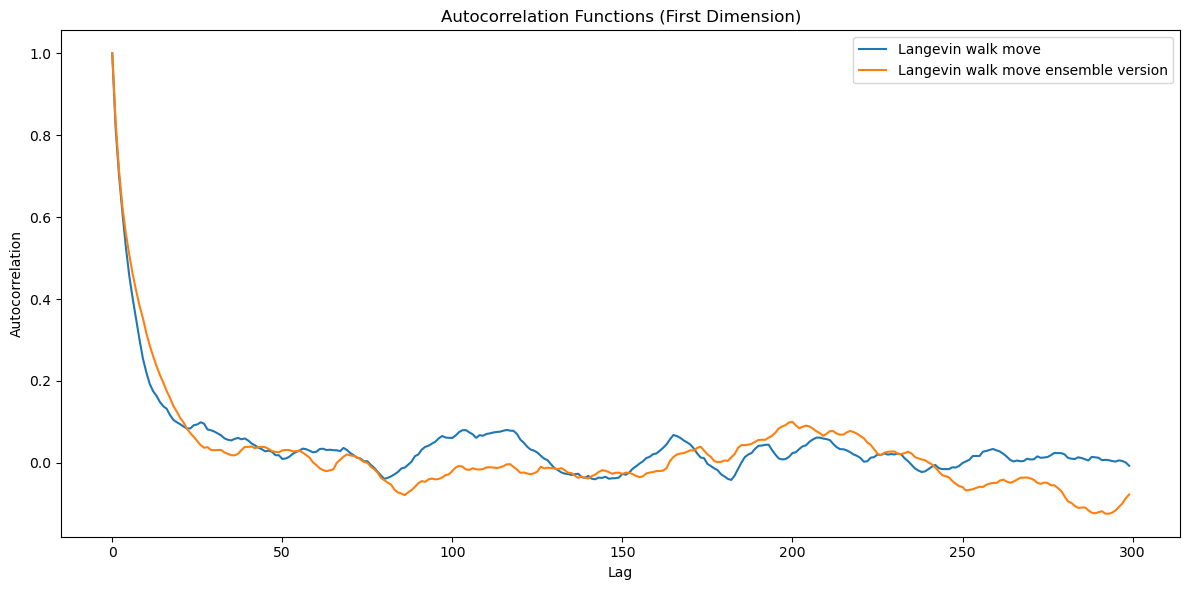

In [8]:
def create_high_dim_precision(dim, condition_number=100):
    """Create a high-dimensional precision matrix with given condition number."""
    # Create random eigenvectors (orthogonal matrix)
    np.random.seed(42)  # For reproducibility
    H = np.random.randn(dim, dim)
    Q, R = np.linalg.qr(H)
    
    # Create eigenvalues with desired condition number
    eigenvalues = 0.1* np.linspace(1, condition_number, dim)
    
    # Construct precision matrix: Q @ diag(eigenvalues) @ Q.T
    precision = Q @ np.diag(eigenvalues) @ Q.T
    
    # Ensure it's symmetric (fix numerical issues)
    precision = 0.5 * (precision + precision.T)
    
    return precision


def benchmark_samplers(dim=40, n_samples=10000, burn_in=1000, condition_number=100):
    """
    Benchmark different MCMC samplers on a high-dimensional Gaussian.
    """
    # Create precision matrix (inverse covariance)
    precision_matrix = create_high_dim_precision(dim, condition_number)
    
    # Compute covariance matrix for reference (needed for evaluation)
    cov_matrix = np.linalg.inv(precision_matrix)
    
    true_mean = np.ones(dim)
    

    def log_density(x):
        """Vectorized log density of the multivariate Gaussian"""
        if x.ndim == 1:
            x = x.reshape(1, -1)
            
        # Vectorized operation for all samples
        centered = x - true_mean
        # Using einsum for efficient batch matrix multiplication
        result = -0.5 * np.einsum('ij,jk,ik->i', centered, precision_matrix, centered)
            
        return result
    
    def gradient(x):
        """Vectorized gradient of the negative log density (potential gradient)"""
        if x.ndim == 1:
            x = x.reshape(1, -1)
            
        # Vectorized operation for all samples
        centered = x - true_mean
        # Matrix multiplication for each sample in the batch
        result = np.einsum('jk,ij->ik', precision_matrix, centered)
            
        return result
    
    def potential(x):
        """Vectorized negative log density (potential energy)"""
        if x.ndim == 1:
            x = x.reshape(1, -1)
            
        # Vectorized operation for all samples
        centered = x - true_mean
        result = 0.5 * np.einsum('ij,jk,ik->i', centered, precision_matrix, centered)
            
        return result
    
    # Initial state
    initial = np.zeros(dim)
    
    # Dictionary to store results
    results = {}
    
    # Define samplers to benchmark with burn-in
    total_samples = n_samples + burn_in
    
    # Define samplers to benchmark - adjust parameters for high-dimensional case
    samplers = {
        "Langevin walk move": lambda: langevin_walk_move(gradient, potential, initial, total_samples, n_chains_per_group=dim, 
                      h=0.2, n_thin=1),
        "Langevin walk move ensemble version": lambda: langevin_walk_move_ensemble(gradient, potential, initial, total_samples, n_chains_per_group=dim, 
                      h=0.2, n_thin=1),           
    }
    
    for name, sampler_func in samplers.items():
        print(f"Running {name}...")
        start_time = time.time()
        samples, acceptance_rates = sampler_func()
        elapsed = time.time() - start_time
        
        # Apply burn-in: discard the first burn_in samples
        post_burn_in_samples = samples[:, burn_in:, :]
        
        # Flatten samples from all chains
        flat_samples = post_burn_in_samples.reshape(-1, dim)
        
        # Compute sample mean and covariance
        sample_mean = np.mean(flat_samples, axis=0)
        sample_cov = np.cov(flat_samples, rowvar=False)
        # Calculate mean squared error for mean and covariance
        mean_mse = np.mean((sample_mean - true_mean)**2) / np.mean(true_mean**2)
        cov_mse = np.sum((sample_cov - cov_matrix)**2) / np.sum(cov_matrix**2)
        
        # Compute autocorrelation for first dimension
        # Average over chains to compute autocorrelation
        acf = autocorrelation_fft(np.mean(samples[:, :, 0],axis=0))
        
        # Compute integrated autocorrelation time for first dimension
        try:
            tau, _, ess = integrated_autocorr_time(np.mean(samples[:, :, 0],axis=0))
        except:
            tau, ess = np.nan, np.nan
        
        # Store results
        results[name] = {
            "samples": flat_samples,
            "acceptance_rates": acceptance_rates,
            "mean_mse": mean_mse,
            "cov_mse": cov_mse,
            "autocorrelation": acf,
            "tau": tau,
            "ess": ess,
            "time": elapsed
        }
        
        print(f"  Acceptance rate: {np.mean(acceptance_rates):.2f}")
        print(f"  Mean MSE: {mean_mse:.6f}")
        print(f"  Covariance MSE: {cov_mse:.6f}")
        print(f"  Integrated autocorrelation time: {tau:.2f}")
        print(f"  Time: {elapsed:.2f} seconds")
    
    return results, true_mean, cov_matrix

def plot_results(results, dim=40, true_mean=None, cov_matrix=None, condition_number=100):
    """Plot comparison of sampler results"""
    samplers = list(results.keys())

    # 1. Plot autocorrelation functions
    plt.figure(figsize=(12, 6))
    for i, name in enumerate(samplers):
        acf = results[name]["autocorrelation"]
        max_lag = min(300, len(acf))
        plt.plot(np.arange(max_lag), acf[:max_lag], label=name)
    
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Functions (First Dimension)")
    plt.legend()
    plt.tight_layout()
    # plt.savefig("autocorrelation.png")
    
    return

# Main execution
# Run benchmarks with higher dimensionality, challenging covariance structure, and burn-in
results, true_mean, cov_matrix = benchmark_samplers(dim=10, n_samples=5000, burn_in=1000, condition_number=1000)

plot_results(results, dim=10, true_mean=true_mean, cov_matrix=cov_matrix, condition_number=1000)


In [17]:
def ensemble_kalman_move(forward_func, initial, n_samples, M=None,
                        n_chains_per_group=5, h=0.01, n_thin=1, use_metropolis=True):
    """
    Ensemble Kalman Move sampler for least squares type densities.
    
    For density π(x) ∝ exp(-V(x)) with V(x) = ½G(x)ᵀMG(x) where G: ℝᵈ → ℝʳ.
    
    The proposal is: x' = x - h * B_S * F_S^T * M * G(x) + √(2h) * B_S * z
    where:
    - B_S: normalized centered ensemble from other group (flat_dim, n_chains_per_group)
    - F_S: normalized centered G(x) from other group (data_dim, n_chains_per_group)  
    - z ~ N(0, I_{n_chains_per_group × n_chains_per_group})
    
    Parameters:
    -----------
    forward_func : callable
        Function G(x) that maps parameters to data space ℝᵈ → ℝʳ
        Must accept batch input: G(x_batch) where x_batch has shape (n_batch, *param_shape)
        Returns array of shape (n_batch, data_dim)
    initial : np.ndarray
        Initial state
    n_samples : int
        Number of samples to collect
    M : np.ndarray, optional
        Precision matrix in data space (default: identity)
    n_chains_per_group : int
        Number of chains per group (default: 5)
    h : float
        Step size (default: 0.01)
    n_thin : int
        Thinning factor (default: 1, no thinning)
    use_metropolis : bool
        Whether to use Metropolis correction for exact sampling (default: True)
    
    Returns:
    --------
    samples : np.ndarray
        Collected samples from all chains
    acceptance_rates : np.ndarray
        Acceptance rates for all chains
    """
    
    # Initialize
    orig_dim = initial.shape
    flat_dim = np.prod(orig_dim)
    total_chains = 2 * n_chains_per_group
    
    # Create initial states with small random perturbations
    states = np.tile(initial.flatten(), (total_chains, 1)) + 0.1 * np.random.randn(total_chains, flat_dim)
    
    # Split into two groups
    group1 = slice(0, n_chains_per_group)
    group2 = slice(n_chains_per_group, total_chains)
    
    # Calculate total iterations needed based on thinning factor
    total_iterations = n_samples * n_thin
    
    # Storage for samples and acceptance tracking
    samples = np.zeros((total_chains, n_samples, flat_dim))
    accepts = np.zeros(total_chains)
    
    # Sample index to track where to store thinned samples
    sample_idx = 0
    
    # Determine data dimension from first forward model evaluation
    test_G = forward_func(initial)
    data_dim = len(test_G)
    
    # Set default M = I if not provided
    if M is None:
        M = np.eye(data_dim)
    
    # Main sampling loop
    for i in range(total_iterations):
        # Store current state from all chains (only every n_thin iterations)
        if i % n_thin == 0 and sample_idx < n_samples:
            samples[:, sample_idx] = states
            sample_idx += 1
        
        # Update group 1 using group 2 for ensemble information
        group2_reshaped = states[group2].reshape(n_chains_per_group, *orig_dim)
        G_group2 = forward_func(group2_reshaped)  # (n_chains_per_group, data_dim)
        mean_G2 = np.mean(G_group2, axis=0)  # (data_dim,)
        
        # F_S1 = (1/√(N/2)) * [G(x_group2) - mean_G2]^T ∈ ℝ^{data_dim × n_chains_per_group}
        F_S1 = ((G_group2 - mean_G2) / np.sqrt(n_chains_per_group)).T  # (data_dim, n_chains_per_group)
        
        # B_S1 from group 2: normalized centered ensemble in parameter space
        group2_centered = states[group2] - np.mean(states[group2], axis=0)
        B_S1 = (group2_centered / np.sqrt(n_chains_per_group)).T  # (flat_dim, n_chains_per_group)
        
        # Vectorized update for group 1
        current_q1 = states[group1].copy()
        current_q1_reshaped = current_q1.reshape(n_chains_per_group, *orig_dim)
        G_current1 = forward_func(current_q1_reshaped)  # (n_chains_per_group, data_dim)
        current_U1 = 0.5 * np.sum(G_current1 * (G_current1 @ M), axis=1)  # (n_chains_per_group,)
        
        # Generate noise z ~ N(0, I_{n_chains_per_group × n_chains_per_group})
        z1 = np.random.randn(n_chains_per_group, n_chains_per_group)
        
        # Ensemble Kalman proposal:
        # x' = x - h * B_S1 * F_S1^T * M * G(x) + √(2h) * B_S1 * z
        
        # Drift term: -h * B_S1 * F_S1^T * M * G(x) (vectorized)
        MG_current1 = G_current1 @ M  # (n_chains_per_group, data_dim)
        drift_terms = -h * (B_S1 @ (F_S1.T @ MG_current1.T)).T  # (n_chains_per_group, flat_dim)
        
        # Noise term: √(2h) * B_S1 * z (vectorized)
        noise_terms = np.sqrt(2 * h) * (B_S1 @ z1.T).T  # (n_chains_per_group, flat_dim)
        
        # Proposed states (vectorized)
        proposed_q1 = current_q1 + drift_terms + noise_terms
        
        if use_metropolis:
            # Metropolis-Hastings correction
            proposed_q1_reshaped = proposed_q1.reshape(n_chains_per_group, *orig_dim)
            G_proposed1 = forward_func(proposed_q1_reshaped)
            proposed_U1 = 0.5 * np.sum(G_proposed1 * (G_proposed1 @ M), axis=1)
            
            # For correct Metropolis step, we need to compute proposal probabilities
            # The proposal has the form: x' ~ N(μ_forward, Σ) where:
            # μ_forward = x - h * B_S1 * F_S1^T * M * G(x)
            # Σ = 2h * B_S1 * B_S1^T (covariance of noise term)
            
            # IMPORTANT: F_S1 is FIXED (from group 2) during this proposal step
            # So both forward and reverse proposals use the SAME F_S1
            
            # Forward proposal mean (what we used to generate proposed_q1)
            mean_forward = current_q1 + drift_terms  # Note: drift_terms already has negative sign
            
            # Reverse proposal: proposed_q1 -> current_q1
            # Mean: proposed_q1 - h * B_S1 * F_S1^T * M * G(proposed_q1)
            # Note: Uses SAME F_S1 (from group 2), not recomputed!
            MG_proposed1 = G_proposed1 @ M
            reverse_drift = -h * (B_S1 @ (F_S1.T @ MG_proposed1.T)).T  # Same F_S1!
            mean_reverse = proposed_q1 + reverse_drift
            
            # Compute residuals
            residual_forward = proposed_q1 - mean_forward  # Should be = noise_terms
            residual_reverse = current_q1 - mean_reverse
            
            # Proposal covariance: The noise term √(2h) * B_S * z has covariance 2h * B_S * B_S^T
            # But for the log probability calculation, we factor out the h:
            # log q = -½ * residual^T * (2h * B_S * B_S^T)^(-1) * residual
            #       = -1/(4h) * residual^T * (B_S * B_S^T)^(-1) * residual
            # So we use cov = B_S * B_S^T (no h) and divide by 4h later
            cov_proposal = np.dot(B_S1, B_S1.T)  # (flat_dim, flat_dim) - NO h here!
            
            try:
                # Use Cholesky for numerical stability
                reg_cov = cov_proposal + 1e-8 * np.eye(flat_dim)
                L = np.linalg.cholesky(reg_cov)
                
                # Compute log proposal probabilities: log q(x' | x) = -½(x' - μ)^T Σ^(-1) (x' - μ)
                # Since Σ = 2h * B_S1 * B_S1^T, we have:
                # log q = -¼h * residual^T * (B_S1 * B_S1^T)^(-1) * residual
                
                # Solve L * y = residual^T for each chain
                Y_forward = np.linalg.solve(L, residual_forward.T)  # (flat_dim, n_chains_per_group)
                Y_reverse = np.linalg.solve(L, residual_reverse.T)   # (flat_dim, n_chains_per_group)
                
                # Log proposal probabilities (factor of 1/(4h) because Σ = 2h * ...)
                log_q_forward = -np.sum(Y_forward**2, axis=0) / (4 * h)
                log_q_reverse = -np.sum(Y_reverse**2, axis=0) / (4 * h)
                
            except np.linalg.LinAlgError:
                # If Cholesky fails, use simpler Metropolis (energy only)
                log_q_forward = np.zeros(n_chains_per_group)
                log_q_reverse = np.zeros(n_chains_per_group)
            
            # Metropolis-Hastings ratio
            dU1 = proposed_U1 - current_U1
            log_ratio = -dU1 + log_q_reverse - log_q_forward
            
            # Accept/reject with numerical stability
            accept_probs1 = np.ones_like(log_ratio)
            exp_needed = log_ratio < 0
            if np.any(exp_needed):
                safe_log_ratio = np.clip(log_ratio[exp_needed], -100, None)
                accept_probs1[exp_needed] = np.exp(safe_log_ratio)
            
            accepts1 = np.random.random(n_chains_per_group) < accept_probs1
            states[group1][accepts1] = proposed_q1[accepts1]
            accepts[group1] += accepts1
        else:
            # Pure Ensemble Kalman (no Metropolis correction)
            states[group1] = proposed_q1
            accepts[group1] += 1  # Always accept
        
        # Update group 2 using group 1 (symmetric structure)
        group1_reshaped = states[group1].reshape(n_chains_per_group, *orig_dim)
        G_group1 = forward_func(group1_reshaped)
        mean_G1 = np.mean(G_group1, axis=0)
        F_S0 = ((G_group1 - mean_G1) / np.sqrt(n_chains_per_group)).T
        
        group1_centered = states[group1] - np.mean(states[group1], axis=0)
        B_S0 = (group1_centered / np.sqrt(n_chains_per_group)).T
        
        current_q2 = states[group2].copy()
        current_q2_reshaped = current_q2.reshape(n_chains_per_group, *orig_dim)
        G_current2 = forward_func(current_q2_reshaped)
        current_U2 = 0.5 * np.sum(G_current2 * (G_current2 @ M), axis=1)
        
        z2 = np.random.randn(n_chains_per_group, n_chains_per_group)
        
        MG_current2 = G_current2 @ M
        drift_terms = -h * (B_S0 @ (F_S0.T @ MG_current2.T)).T
        noise_terms = np.sqrt(2 * h) * (B_S0 @ z2.T).T
        proposed_q2 = current_q2 + drift_terms + noise_terms
        
        if use_metropolis:
            proposed_q2_reshaped = proposed_q2.reshape(n_chains_per_group, *orig_dim)
            G_proposed2 = forward_func(proposed_q2_reshaped)
            proposed_U2 = 0.5 * np.sum(G_proposed2 * (G_proposed2 @ M), axis=1)
            
            mean_forward = current_q2 + drift_terms
            
            # Reverse proposal: proposed_q2 -> current_q2  
            # Mean: proposed_q2 - h * B_S0 * F_S0^T * M * G(proposed_q2)
            # Note: Uses SAME F_S0 (from group 1), not recomputed!
            MG_proposed2 = G_proposed2 @ M
            reverse_drift = -h * (B_S0 @ (F_S0.T @ MG_proposed2.T)).T  # Same F_S0!
            mean_reverse = proposed_q2 + reverse_drift
            
            residual_forward = proposed_q2 - mean_forward
            residual_reverse = current_q2 - mean_reverse
            
            cov_proposal = np.dot(B_S0, B_S0.T)  # NO h here!
            
            try:
                reg_cov = cov_proposal + 1e-8 * np.eye(flat_dim)
                L = np.linalg.cholesky(reg_cov)
                
                Y_forward = np.linalg.solve(L, residual_forward.T)
                Y_reverse = np.linalg.solve(L, residual_reverse.T)
                
                log_q_forward = -np.sum(Y_forward**2, axis=0) / (4 * h)
                log_q_reverse = -np.sum(Y_reverse**2, axis=0) / (4 * h)
                
            except np.linalg.LinAlgError:
                log_q_forward = np.zeros(n_chains_per_group)
                log_q_reverse = np.zeros(n_chains_per_group)
            
            dU2 = proposed_U2 - current_U2
            log_ratio = -dU2 + log_q_reverse - log_q_forward
            
            accept_probs2 = np.ones_like(log_ratio)
            exp_needed = log_ratio < 0
            if np.any(exp_needed):
                safe_log_ratio = np.clip(log_ratio[exp_needed], -100, None)
                accept_probs2[exp_needed] = np.exp(safe_log_ratio)
            
            accepts2 = np.random.random(n_chains_per_group) < accept_probs2
            states[group2][accepts2] = proposed_q2[accepts2]
            accepts[group2] += accepts2
        else:
            states[group2] = proposed_q2
            accepts[group2] += 1
    
    # Reshape final samples to original dimensions
    samples = samples.reshape((total_chains, n_samples) + orig_dim)
    
    # Compute acceptance rates
    acceptance_rates = accepts / total_iterations
    
    return samples, acceptance_rates

In [36]:
def create_high_dim_precision(dim, condition_number=100):
    """Create a high-dimensional precision matrix with given condition number."""
    # Create random eigenvectors (orthogonal matrix)
    np.random.seed(42)  # For reproducibility
    H = np.random.randn(dim, dim)
    Q, R = np.linalg.qr(H)
    
    # Create eigenvalues with desired condition number
    eigenvalues = 0.1* np.linspace(1, condition_number, dim)
    
    # Construct precision matrix: Q @ diag(eigenvalues) @ Q.T
    precision = Q @ np.diag(eigenvalues) @ Q.T
    
    # Ensure it's symmetric (fix numerical issues)
    precision = 0.5 * (precision + precision.T)
    
    return precision

def test_ensemble_kalman_move(dim=20, n_samples=10000, burn_in=2000, condition_number=1000):
    """
    Test the Ensemble Kalman Move on a high-dimensional Gaussian problem.
    
    We construct a least squares problem equivalent to sampling from a multivariate Gaussian:
    π(x) ∝ exp(-½(x-μ)ᵀ Λ (x-μ)) = exp(-½||G(x)||²_M)
    
    where G(x) = L(x-μ) and M = I, with L such that L^T L = Λ (precision matrix)
    """
    
    # Create precision matrix (same as original test)
    precision_matrix = create_high_dim_precision(dim, condition_number)
    cov_matrix = np.linalg.inv(precision_matrix)
    true_mean = np.ones(dim)
    
    # For Ensemble Kalman Move, we need to construct:
    # G(x): ℝᵈ → ℝʳ such that V(x) = ½||G(x)||²_M = ½(x-μ)ᵀ Λ (x-μ)
    
    # Much simpler solution: G(x) = x - μ and M = Λ (precision matrix)
    # Then: V(x) = ½||x-μ||²_Λ = ½(x-μ)ᵀ Λ (x-μ) ✓
    
    def forward_func(x_batch):
        """
        Forward model G(x) = x - μ
        x_batch: (n_batch, dim)
        returns: (n_batch, dim)  # data dimension = parameter dimension
        """
        if x_batch.ndim == 1:
            x_batch = x_batch.reshape(1, -1)
        
        # G(x) = x - μ
        return x_batch - true_mean  # (n_batch, dim)
    
    # For this construction, M = Λ (precision matrix)
    M = precision_matrix
    
    # Verify that our construction is correct:
    # V(x) = ½||G(x)||²_M = ½||x-μ||²_Λ = ½(x-μ)ᵀ Λ (x-μ) ✓
    
    # Test on a single point to verify both formulations are equivalent
    test_x = np.random.randn(dim)
    
    # Ensemble Kalman formulation: V = ½||G(x)||²_M
    G_test = forward_func(test_x)
    V_kalman = 0.5 * np.sum(G_test * (G_test @ M))
    
    # Langevin formulation: V = ½(x-μ)^T Λ (x-μ)  
    V_langevin = 0.5 * (test_x - true_mean) @ precision_matrix @ (test_x - true_mean)
    
    print(f"Verification - Kalman V: {V_kalman:.6f}, Langevin V: {V_langevin:.6f}, Diff: {abs(V_kalman - V_langevin):.2e}")
    
    # Test drift equivalence on a simple case
    print("\n=== Drift Direction Test ===")
    test_states = np.array([np.zeros(dim), true_mean + 0.1*np.random.randn(dim)])
    print(f"Test states: {test_states}")
    
    # For Ensemble Kalman: drift should point towards lower energy
    G_test_batch = forward_func(test_states)
    print(f"G(test_states): {G_test_batch}")
    V_test = 0.5 * np.sum(G_test_batch * (G_test_batch @ M), axis=1)
    print(f"Energies: {V_test}")
    
    # Check if algorithm moves towards true mean
    direction_to_mean = true_mean - test_states[0]  # Should point towards [1,1,1,...]
    print(f"Direction to true mean: {direction_to_mean}")
    print(f"Should be positive (towards true mean): {np.all(direction_to_mean > 0)}")
    
    # Also verify gradient
    grad_test = (precision_matrix @ (test_x - true_mean).reshape(-1, 1)).flatten()
    grad_expected = precision_matrix @ (test_x - true_mean)
    print(f"Gradient difference: {np.linalg.norm(grad_test - grad_expected):.2e}")
    
    # Initial state
    initial = np.zeros(dim)
    
    # Dictionary to store results
    results = {}
    
    # Define samplers to benchmark
    total_samples = n_samples + burn_in
    
    samplers = {
        "Ensemble Kalman Move (h=0.2, metro)": lambda: ensemble_kalman_move(
            forward_func, initial, total_samples, M=M,
            n_chains_per_group=dim, h=0.2, n_thin=1, use_metropolis=True
        ),
        "Ensemble Kalman Move (h=0.2, pure)": lambda: ensemble_kalman_move(
            forward_func, initial, total_samples, M=M,
            n_chains_per_group=dim, h=0.2, n_thin=1, use_metropolis=False
        ),
        "Ensemble Kalman Move (h=0.1, pure)": lambda: ensemble_kalman_move(
            forward_func, initial, total_samples, M=M,
            n_chains_per_group=dim, h=0.1, n_thin=1, use_metropolis=False
        ),
        "Ensemble Kalman Move (h=0.05, pure)": lambda: ensemble_kalman_move(
            forward_func, initial, total_samples, M=M,
            n_chains_per_group=dim, h=0.05, n_thin=1, use_metropolis=False
        ),
        # Keep Langevin for comparison
        "Langevin walk move ensemble version": lambda: langevin_walk_move_ensemble(
            lambda x: (precision_matrix @ (x - true_mean).T).T,  # gradient of potential
            lambda x: 0.5 * np.sum((x - true_mean) * ((x - true_mean) @ precision_matrix), axis=1),  # potential
            initial, total_samples, n_chains_per_group=dim, h=0.2, n_thin=1
        ),
    }
    
    for name, sampler_func in samplers.items():
        print(f"Running {name}...")
        start_time = time.time()
        
        try:
            samples, acceptance_rates = sampler_func()
            elapsed = time.time() - start_time
            
            # Apply burn-in: discard the first burn_in samples
            post_burn_in_samples = samples[:, burn_in:, :]
            
            # Flatten samples from all chains
            flat_samples = post_burn_in_samples.reshape(-1, dim)
            
            # Compute sample mean and covariance
            sample_mean = np.mean(flat_samples, axis=0)
            sample_cov = np.cov(flat_samples, rowvar=False)
            
            # Calculate mean squared error for mean and covariance
            mean_mse = np.mean((sample_mean - true_mean)**2) / np.mean(true_mean**2)
            cov_mse = np.sum((sample_cov - cov_matrix)**2) / np.sum(cov_matrix**2)
            
            # Compute autocorrelation for first dimension
            # Average over chains to compute autocorrelation
            acf = autocorrelation_fft(np.mean(samples[:, :, 0], axis=0))
            
            # Compute integrated autocorrelation time for first dimension
            try:
                tau, _, ess = integrated_autocorr_time(np.mean(samples[:, :, 0], axis=0))
            except:
                tau, ess = np.nan, np.nan
            
            # Store results
            results[name] = {
                "samples": flat_samples,
                "acceptance_rates": acceptance_rates,
                "mean_mse": mean_mse,
                "cov_mse": cov_mse,
                "autocorrelation": acf,
                "tau": tau,
                "ess": ess,
                "time": elapsed
            }
            
            print(f"  Acceptance rate: {np.mean(acceptance_rates):.2f}")
            print(f"  Mean MSE: {mean_mse:.6f}")
            print(f"  Covariance MSE: {cov_mse:.6f}")
            print(f"  Integrated autocorrelation time: {tau:.2f}")
            print(f"  Time: {elapsed:.2f} seconds")
            
        except Exception as e:
            print(f"  ERROR: {e}")
            continue
    
    return results, true_mean, cov_matrix


def test_ensemble_kalman_nonlinear(dim=10, n_samples=5000, burn_in=1000):
    """
    Test Ensemble Kalman Move on a nonlinear least squares problem.
    
    Forward model: G(x) = sin(A @ x) + noise_level * x
    Data: d = G(x_true) + ε where ε ~ N(0, σ²I)
    
    Target: π(x) ∝ exp(-½||G(x) - d||²_M) where M = (1/σ²)I
    """
    np.random.seed(123)  # For reproducibility
    
    # Create synthetic problem
    data_dim = dim + 5  # More data than parameters (overdetermined)
    A = np.random.randn(data_dim, dim) * 0.5
    noise_level = 0.1
    
    # True parameters and forward model
    x_true = np.random.randn(dim) * 0.5
    
    def true_forward_model(x):
        """True forward model G(x)"""
        if x.ndim == 1:
            # x has shape (dim,), A @ x has shape (data_dim,)
            linear_part = A @ x  # (data_dim,)
            return np.sin(linear_part) + noise_level * linear_part  # Both (data_dim,)
        else:
            # x has shape (n_batch, dim), result should be (n_batch, data_dim)
            linear_part = x @ A.T  # (n_batch, data_dim)
            return np.sin(linear_part) + noise_level * linear_part  # Both (n_batch, data_dim)
    
    # Generate synthetic data with noise
    noise_std = 0.1  # Standard deviation of measurement noise
    true_data = true_forward_model(x_true) + noise_std * np.random.randn(data_dim)
    
    # Precision matrix (inverse noise covariance)
    M = np.eye(data_dim) / (noise_std**2)  # M = (1/σ²)I - CORRECT!
    
    def forward_func(x_batch):
        """
        Forward model for Ensemble Kalman: G(x) - d
        This gives the residual, so V(x) = ½||G(x) - d||²_M
        
        x_batch: (n_batch, dim)
        returns: (n_batch, data_dim)
        """
        if x_batch.ndim == 1:
            x_batch = x_batch.reshape(1, -1)
        
        # G(x) - d (residual)
        G_x = true_forward_model(x_batch)  # Forward model evaluation
        residual = G_x - true_data  # Subtract observed data
        return residual
    
    # Alternative: define forward model and data separately (cleaner)
    def forward_func_clean(x_batch):
        """
        Clean version: just return G(x), let the algorithm handle G(x) - d
        """
        return true_forward_model(x_batch)
    
    # For cleaner implementation, we'd need to modify the Ensemble Kalman Move
    # to accept both forward_func and observed_data. For now, use residual version.
    
    # Initial state
    initial = np.zeros(dim)
    
    print("Testing Ensemble Kalman Move on nonlinear least squares problem...")
    print(f"Parameter dim: {dim}, Data dim: {data_dim}")
    print(f"True parameters: {x_true}")
    print(f"Noise std: {noise_std}, M condition number: {np.linalg.cond(M):.2e}")
    print(f"Data range: [{np.min(true_data):.3f}, {np.max(true_data):.3f}]")
    
    # Test both versions
    total_samples = n_samples + burn_in
    
    print("\n=== With Metropolis correction ===")
    start_time = time.time()
    samples_metro, rates_metro = ensemble_kalman_move(
        forward_func, initial, total_samples, M=M,
        n_chains_per_group=dim, h=0.01, use_metropolis=True
    )
    time_metro = time.time() - start_time
    
    print("\n=== Pure Ensemble Kalman ===")
    start_time = time.time()
    samples_pure, rates_pure = ensemble_kalman_move(
        forward_func, initial, total_samples, M=M,
        n_chains_per_group=dim, h=0.01, use_metropolis=False
    )
    time_pure = time.time() - start_time
    
    # Analyze results
    samples_metro_burned = samples_metro[:, burn_in:, :].reshape(-1, dim)
    samples_pure_burned = samples_pure[:, burn_in:, :].reshape(-1, dim)
    
    mean_metro = np.mean(samples_metro_burned, axis=0)
    mean_pure = np.mean(samples_pure_burned, axis=0)
    
    # Compute data fit for both estimates
    metro_data_fit = np.linalg.norm(true_forward_model(mean_metro) - true_data)
    pure_data_fit = np.linalg.norm(true_forward_model(mean_pure) - true_data)
    true_data_fit = np.linalg.norm(true_forward_model(x_true) - true_data)  # Should be ≈ noise_std * √data_dim
    
    print(f"\nResults:")
    print(f"True parameters:     {x_true}")
    print(f"Metropolis mean:     {mean_metro}")
    print(f"Pure EKM mean:       {mean_pure}")
    print(f"Metro param bias:    {np.linalg.norm(mean_metro - x_true):.4f}")
    print(f"Pure param bias:     {np.linalg.norm(mean_pure - x_true):.4f}")
    print(f"Metro data fit:      {metro_data_fit:.4f}")
    print(f"Pure data fit:       {pure_data_fit:.4f}")
    print(f"True data fit:       {true_data_fit:.4f} (expected ≈ {noise_std * np.sqrt(data_dim):.4f})")
    print(f"Metro acc rate:      {np.mean(rates_metro):.3f}")
    print(f"Pure acc rate:       {np.mean(rates_pure):.3f}")
    print(f"Metro time:          {time_metro:.2f}s")
    print(f"Pure time:           {time_pure:.2f}s")
    
    return {
        'metropolis': {'samples': samples_metro_burned, 'rates': rates_metro, 'time': time_metro},
        'pure': {'samples': samples_pure_burned, 'rates': rates_pure, 'time': time_pure},
        'true_params': x_true,
        'data_fit': {'metro': metro_data_fit, 'pure': pure_data_fit, 'true': true_data_fit}
    }




def plot_results(results, dim=40, true_mean=None, cov_matrix=None, condition_number=100):
    """Plot comparison of sampler results"""
    samplers = list(results.keys())

    # 1. Plot autocorrelation functions
    plt.figure(figsize=(12, 6))
    for i, name in enumerate(samplers):
        acf = results[name]["autocorrelation"]
        max_lag = min(300, len(acf))
        plt.plot(np.arange(max_lag), acf[:max_lag], label=name)
    
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("Autocorrelation Functions (First Dimension)")
    plt.legend()
    plt.tight_layout()
    # plt.savefig("autocorrelation.png")
    
    return

# Example usage:
if __name__ == "__main__":
    # Test 1: Linear Gaussian problem (equivalent to multivariate Gaussian sampling)
    print("=" * 60)
    print("TEST 1: Linear least squares (equivalent to Gaussian sampling)")
    print("=" * 60)
    # results, true_mean, cov_matrix = test_ensemble_kalman_move(dim=5, n_samples=10000, burn_in=2000, condition_number=1000)
    
    # if results:
    #     plot_results(results, dim=5, true_mean=true_mean, cov_matrix=cov_matrix, condition_number=1000)
    
    print("\n" + "=" * 60)
    print("TEST 2: Nonlinear least squares problem")
    print("=" * 60)
    nonlinear_results = test_ensemble_kalman_nonlinear(dim=5, n_samples=10000, burn_in=2000)


TEST 1: Linear least squares (equivalent to Gaussian sampling)

TEST 2: Nonlinear least squares problem
Testing Ensemble Kalman Move on nonlinear least squares problem...
Parameter dim: 5, Data dim: 10
True parameters: [-0.64704266 -0.51939411  0.87185611 -0.39903137  0.01484162]
Noise std: 0.1, M condition number: 1.00e+00
Data range: [-0.978, 1.129]

=== With Metropolis correction ===

=== Pure Ensemble Kalman ===

Results:
True parameters:     [-0.64704266 -0.51939411  0.87185611 -0.39903137  0.01484162]
Metropolis mean:     [-0.54567296 -0.5359145   0.99841173 -0.48967855  0.10619208]
Pure EKM mean:       [-0.53446891 -0.5157908   0.97219556 -0.47828153  0.0925719 ]
Metro param bias:    0.2077
Pure param bias:     0.1873
Metro data fit:      0.3190
Pure data fit:       0.3169
True data fit:       0.3673 (expected ≈ 0.3162)
Metro acc rate:      0.983
Pure acc rate:       1.000
Metro time:          2.10s
Pure time:           0.76s
